In [1]:
import numpy as np
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt

import pandas as pd

from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper

/home/tschernn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
## import features and charter list

array_path = r"/home/tschernn/clustering/img_array.pkl"

with open(array_path, 'rb') as file:
    img_array = pickle.load(file)

feature_path = r"/home/tschernn/clustering/features_vgg.pkl"

with open(feature_path, 'rb') as file:
    data = pickle.load(file)

charter_path = r"/home/tschernn/clustering/charter_list.pkl"

with open(charter_path, 'rb') as file:
    charters = pickle.load(file)

data.shape

(155, 4096)

In [10]:
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(data)
embedding.shape

(155, 2)

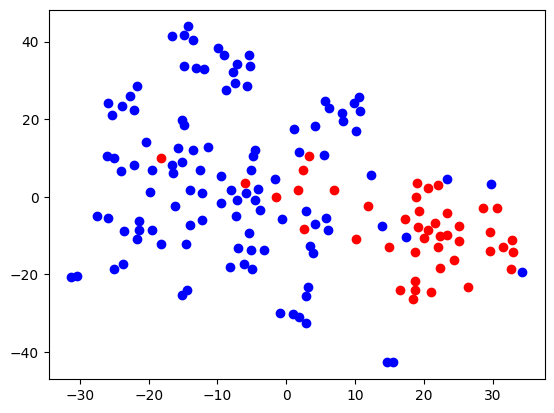

In [11]:
## plot data

label_color_map = {
    'writable_area_notar': 'red',
    'writable_area_papst_oe': 'blue'
}

for point, charter in zip(embedding, charters):
    x,y = point
    label = charter[1]
    color = label_color_map[label]
    plt.scatter(x, y, c=color)

In [12]:
### export data as pickle file
feature_path = feature_path.split('.')[0]
feature_path = feature_path + '_dimred.pkl'

with open(feature_path,'wb') as file:
    pickle.dump(embedding, file)
    print(f'Saved features as {file.name}.')

Saved features as /home/tschernn/clustering/features_vgg_dimred.pkl.


In [13]:
### bokeh implementation adapted from https://umap-learn.readthedocs.io/en/latest/basic_usage.html

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((256, 256), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

## draw plot

output_notebook()

charters_df = pd.DataFrame(embedding, columns=('x', 'y'))
charters_df['class'] = [x[1] for x in charters]
charters_df['image'] = list(map(embeddable_image, img_array))
charters_df['name'] = [x[0] for x in charters]

datasource = ColumnDataSource(charters_df)
color_mapping = CategoricalColorMapper(factors=['writable_area_notar', 'writable_area_papst_oe'],
                                       palette=["red", "blue"])

plot_figure = figure(
    title='UMAP projection of the charters',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Charter:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

plot_figure.scatter(
    'x',
    'y',
    source=datasource,
    color=dict(field='class', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

Loading BokehJS ...